# Benchmarking gRPC vs REST API

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
import requests
import numpy as np
import json
from tqdm import tqdm

In [4]:
from time import time

In [5]:
from apis import *

#### Data functions

In [6]:
def get_fashion_mnist():
    _, (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
    # reshape data
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
    # scale the values to 0.0 to 1.0
    test_images = test_images / 255.0
    return test_images, test_labels

In [7]:
def get_mnist():
    _, (test_images, test_labels) = keras.datasets.mnist.load_data()
    # reshape data
    test_images = test_images.reshape(test_images.shape[0], -1)
    # scale the values to 0.0 to 1.0
    test_images = test_images / 255.0
    return test_images, test_labels    

#### gRPC and HTTP requests functions

In [8]:
def time_for_grpc_requests(proto_request_list, server='0.0.0.0:8500'):
    prediction_service = PredictionService(server)
    proto_response_list = []
    st = time()
    for req in tqdm(proto_request_list):
        response = PredictResponse().copy(prediction_service.predict(req._protobuf, 5))
        proto_response_list.append(response)
    et = time()
    return et-st, proto_response_list

In [9]:
def time_for_http_requests(json_request_list, server_url='http://localhost:8501/v1/models/fashion_model:predict'):
    json_response_list = []
    headers = {"content-type": "application/json"}

    st = time()
    for req in tqdm(json_request_list):
        json_response = requests.post(server_url, data=req, headers=headers)
        json_response.raise_for_status()
        json_response_list.append(json_response) 
    et = time()
    return et-st, json_response_list

In [10]:
def create_request(dataset, test_images, batch_size):
    proto_request_list = []
    json_request_list = []
    
    if dataset == 'fashion_mnist':
        proto_pred_request = PredictRequest(model_spec=ModelSpec(name='fashion_model', version=1, signature_name='serving_default'))
        json_pred_request = {"signature_name": "serving_default"}
    elif dataset == 'mnist':
        proto_pred_request = PredictRequest(model_spec=ModelSpec(name='mnist', version=1, signature_name='predict_images'))
        json_pred_request = {"signature_name": "predict_images"}
        
    for i in range(0, len(test_images), batch_size):
        # protobuf message
        if dataset == 'fashion_mnist':
            proto_pred_request.inputs = {'input_image': {'values' : test_images[i:i+batch_size,:].astype(np.float32)}}
        elif dataset == 'mnist':
            proto_pred_request.inputs = {'images' : {'values' : test_images[i:i+batch_size,:].astype(np.float32)}}
        proto_request_list.append(proto_pred_request)
        
        # json message
        json_pred_request.update({'instances' : test_images[i:i+batch_size,:].tolist()})
        json_request_list.append(json.dumps(json_pred_request))
        
    return proto_request_list, json_request_list

In [11]:
def latency_profile_http_vs_grpc(dataset, batch_size, num_samples=10000):
    if dataset == 'fashion_mnist':
        test_images, test_labels = get_fashion_mnist()
        grpc_server = '0.0.0.0:8500'
        http_rest_server = 'http://localhost:8501/v1/models/fashion_model:predict'
    elif dataset == 'mnist':
        test_images, test_labels = get_mnist()
        grpc_server = '0.0.0.0:8500'
        http_rest_server = r='http://localhost:8501/v1/models/mnist:predict'
    else:
        raise ValueError('Wrong dataset type!')
        
    test_images = test_images[:num_samples]
    test_labels = test_labels[:num_samples]
        
    proto_request_list, json_request_list = create_request(dataset, test_images, batch_size)
    
    grpc_time = time_for_grpc_requests(proto_request_list, server=grpc_server)
    print('GRPC-DONE: Batch Size: {}, Time: {}'.format(batch_size, grpc_time))
    rest_time = time_for_http_requests(json_request_list, server_url=http_rest_server)
    print('HTTP-DONE: Batch Size: {}, Time: {}'.format(batch_size, rest_time))
    
    return grpc_time, rest_time

In [15]:
batch_sizes = [1, 4, 8, 16]

In [16]:
batch_sizes

[1, 4, 8, 16]

In [17]:
latency_profile_against_batches = []
for batch_size in batch_sizes:
    latency_profile_against_batches.append(latency_profile_http_vs_grpc('mnist', batch_size))

  0%|          | 37/10000 [00:00<00:27, 368.49it/s]

GRPC-DONE: Batch Size: 1, Time: 3.7817211151123047


100%|██████████| 10000/10000 [00:26<00:00, 371.68it/s]


HTTP-DONE: Batch Size: 1, Time: 26.906493186950684


  1%|▏         | 35/2500 [00:00<00:07, 345.25it/s]

GRPC-DONE: Batch Size: 4, Time: 1.0227878093719482


100%|██████████| 2500/2500 [00:07<00:00, 355.05it/s]


HTTP-DONE: Batch Size: 4, Time: 7.045127630233765


  3%|▎         | 33/1250 [00:00<00:03, 326.47it/s]

GRPC-DONE: Batch Size: 8, Time: 0.5525126457214355


100%|██████████| 1250/1250 [00:03<00:00, 327.84it/s]


HTTP-DONE: Batch Size: 8, Time: 3.8154640197753906


  4%|▍         | 28/625 [00:00<00:02, 278.78it/s]

GRPC-DONE: Batch Size: 16, Time: 0.32400035858154297


100%|██████████| 625/625 [00:02<00:00, 265.68it/s]

HTTP-DONE: Batch Size: 16, Time: 2.3553247451782227


In [18]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

In [33]:
def plot_latencies(latency_profile_against_batches, dataset):
    N = len(latency_profile_against_batches)

    grpc_latencies = [x[0] for x in latency_profile_against_batches]
    http_latencies = [x[1] for x in latency_profile_against_batches]

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots(figsize=(10,8))
    rects1 = ax.bar(ind, grpc_latencies, width, color='royalblue')
    rects2 = ax.bar(ind+width, http_latencies, width, color='seagreen')

    # add some
    ax.set_ylabel('Latency (s)')
    ax.set_xlabel('Batch Sizes')
    ax.set_title('''Latency comparison between gRPC vs REST `predict` requests 
                    on  {} dataset'''.format(dataset))
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels( ('1', '4', '8', '16') )

    ax.legend( (rects1[0], rects2[0]), ('GRPC/PB', 'HTTP/JSON') )
    plt.savefig('latency-comp-{}.png'.format(dataset))
    plt.show()

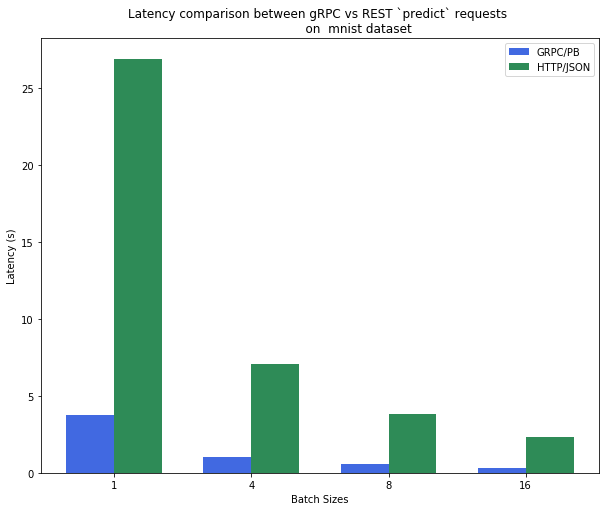

In [34]:
plot_latencies(latency_profile_against_batches, 'mnist')

The gRPC request are processed on average 6 times faster than HTTP requests.

Future tests: Need to add